This notebook is a part of the work 'Nucleation patterns of polymer crystals analyzed by machine learning models' and is written by Atmika Bhardwaj (bhardwaj@ipfdd.de).

The following machine learning models are employed in this notebook: AutoEncoders (AE), Hierarchical Clustering (HC), Gaussian Mixture Models (GMM), Multilayer Perceptron (MLP). We start by reading a coordinate file (dump file from LAMMPS) and analyze it to study the local environmental information of every coarse-grained bead. Then, we train an AE to compress that information and train a GMM on the compressed data to classify each coarse-grained into amorphous or crytalline depending on its enviromental fingerprint.

This notebook imports all the functions from another file called all_functions.py


In [1]:
import glob
import random
import pickle
import numpy                  as     np
from   numpy.random           import seed
import matplotlib.pyplot      as     plt
import matplotlib.cm          as     cm
import h5py                   as     h5py
from   mpl_toolkits.mplot3d   import Axes3D
from   natsort                import natsorted
from   sklearn                import preprocessing, mixture
from   sklearn.cluster        import AgglomerativeClustering
from   keras.models           import load_model
import sys
sys.path.insert(0, '../../../Jupyters/')
from   all_functions          import *
import matplotlib.ticker      as mticker
seed(1)
plt.rcParams["figure.figsize"]  = (6,5)
plt.rcParams["figure.dpi"]      = 300
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

2023-09-26 17:02:39.417049: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-26 17:02:39.417071: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
chainLength      = 1000
dx               = 0.4
Rmax             = 3.5
hid_dim          = 14
depth            = 14
nEpochs          = 650  #800
VL               = 1
batchSize        = 20
validationSplit  = 0.2
L2               = 10e-7
LR               = 10e-5
g                = natsorted(glob.glob('../../../../01_raw_data/dump_files/dump.*'))


In [3]:
h5_file          = h5py.File('../../../all_parameters.h5', 'r')
h5_keys          = natsorted(list(h5_file.keys()))
file_num         = -1
obj              = ReadCoordinates(g[file_num], chainLength)
rnd              = get_slice_indices(obj, 100, 15, axis = 2)
ae_training_data = np.array(h5_file.get(h5_keys[file_num]))[rnd]
ae_training_data = np.delete(ae_training_data, 10, axis = 1)
print(ae_training_data.shape)









(10038, 17)


In [4]:
autoencoder, encoder, hist, encoded = fixedSeeds(2, hid_dim, ae_training_data, depth, "elu", L2, VL, nEpochs, LR, validationSplit, batchSize, 'ae_slice.sav')

histories = [hist]
names     = ["AE History curve 75", "hist2"]
fig = plt.figure()
plt.xscale("log")
ax  = plt.axes(xscale='log', yscale='log')
ax.grid()
c=0
for h in histories:
    l  = h.history["loss"]
    lv = h.history["val_loss"]
    t  = np.arange(len(l))
    name=names[c]
    plt.plot(t, lv , label=name)
    c+=1
plt.ylim(0,0.5)
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()


Epoch 1/650


2023-09-26 17:03:02.419549: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-26 17:03:02.420114: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-26 17:03:02.420149: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-09-26 17:03:02.420181: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-09-26 17:03:02.420212: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

402/402 [==============================] - 2s 2ms/step - loss: 0.3498 - val_loss: 0.1501 - lr: 1.0000e-04
Epoch 2/650
402/402 [==============================] - 1s 2ms/step - loss: 0.1069 - val_loss: 0.0877 - lr: 1.0000e-04
Epoch 3/650
402/402 [==============================] - 1s 2ms/step - loss: 0.0847 - val_loss: 0.0800 - lr: 1.0000e-04
Epoch 4/650
402/402 [==============================] - 1s 2ms/step - loss: 0.0787 - val_loss: 0.0754 - lr: 1.0000e-04
Epoch 5/650
402/402 [==============================] - 1s 2ms/step - loss: 0.0743 - val_loss: 0.0710 - lr: 1.0000e-04
Epoch 6/650
402/402 [==============================] - 1s 2ms/step - loss: 0.0706 - val_loss: 0.0676 - lr: 1.0000e-04
Epoch 7/650
402/402 [==============================] - 1s 2ms/step - loss: 0.0678 - val_loss: 0.0651 - lr: 1.0000e-04
Epoch 8/650
402/402 [==============================] - 1s 2ms/step - loss: 0.0657 - val_loss: 0.0633 - lr: 1.0000e-04
Epoch 9/650
402/402 [==============================] - 1s 2ms/step -

KeyboardInterrupt: 

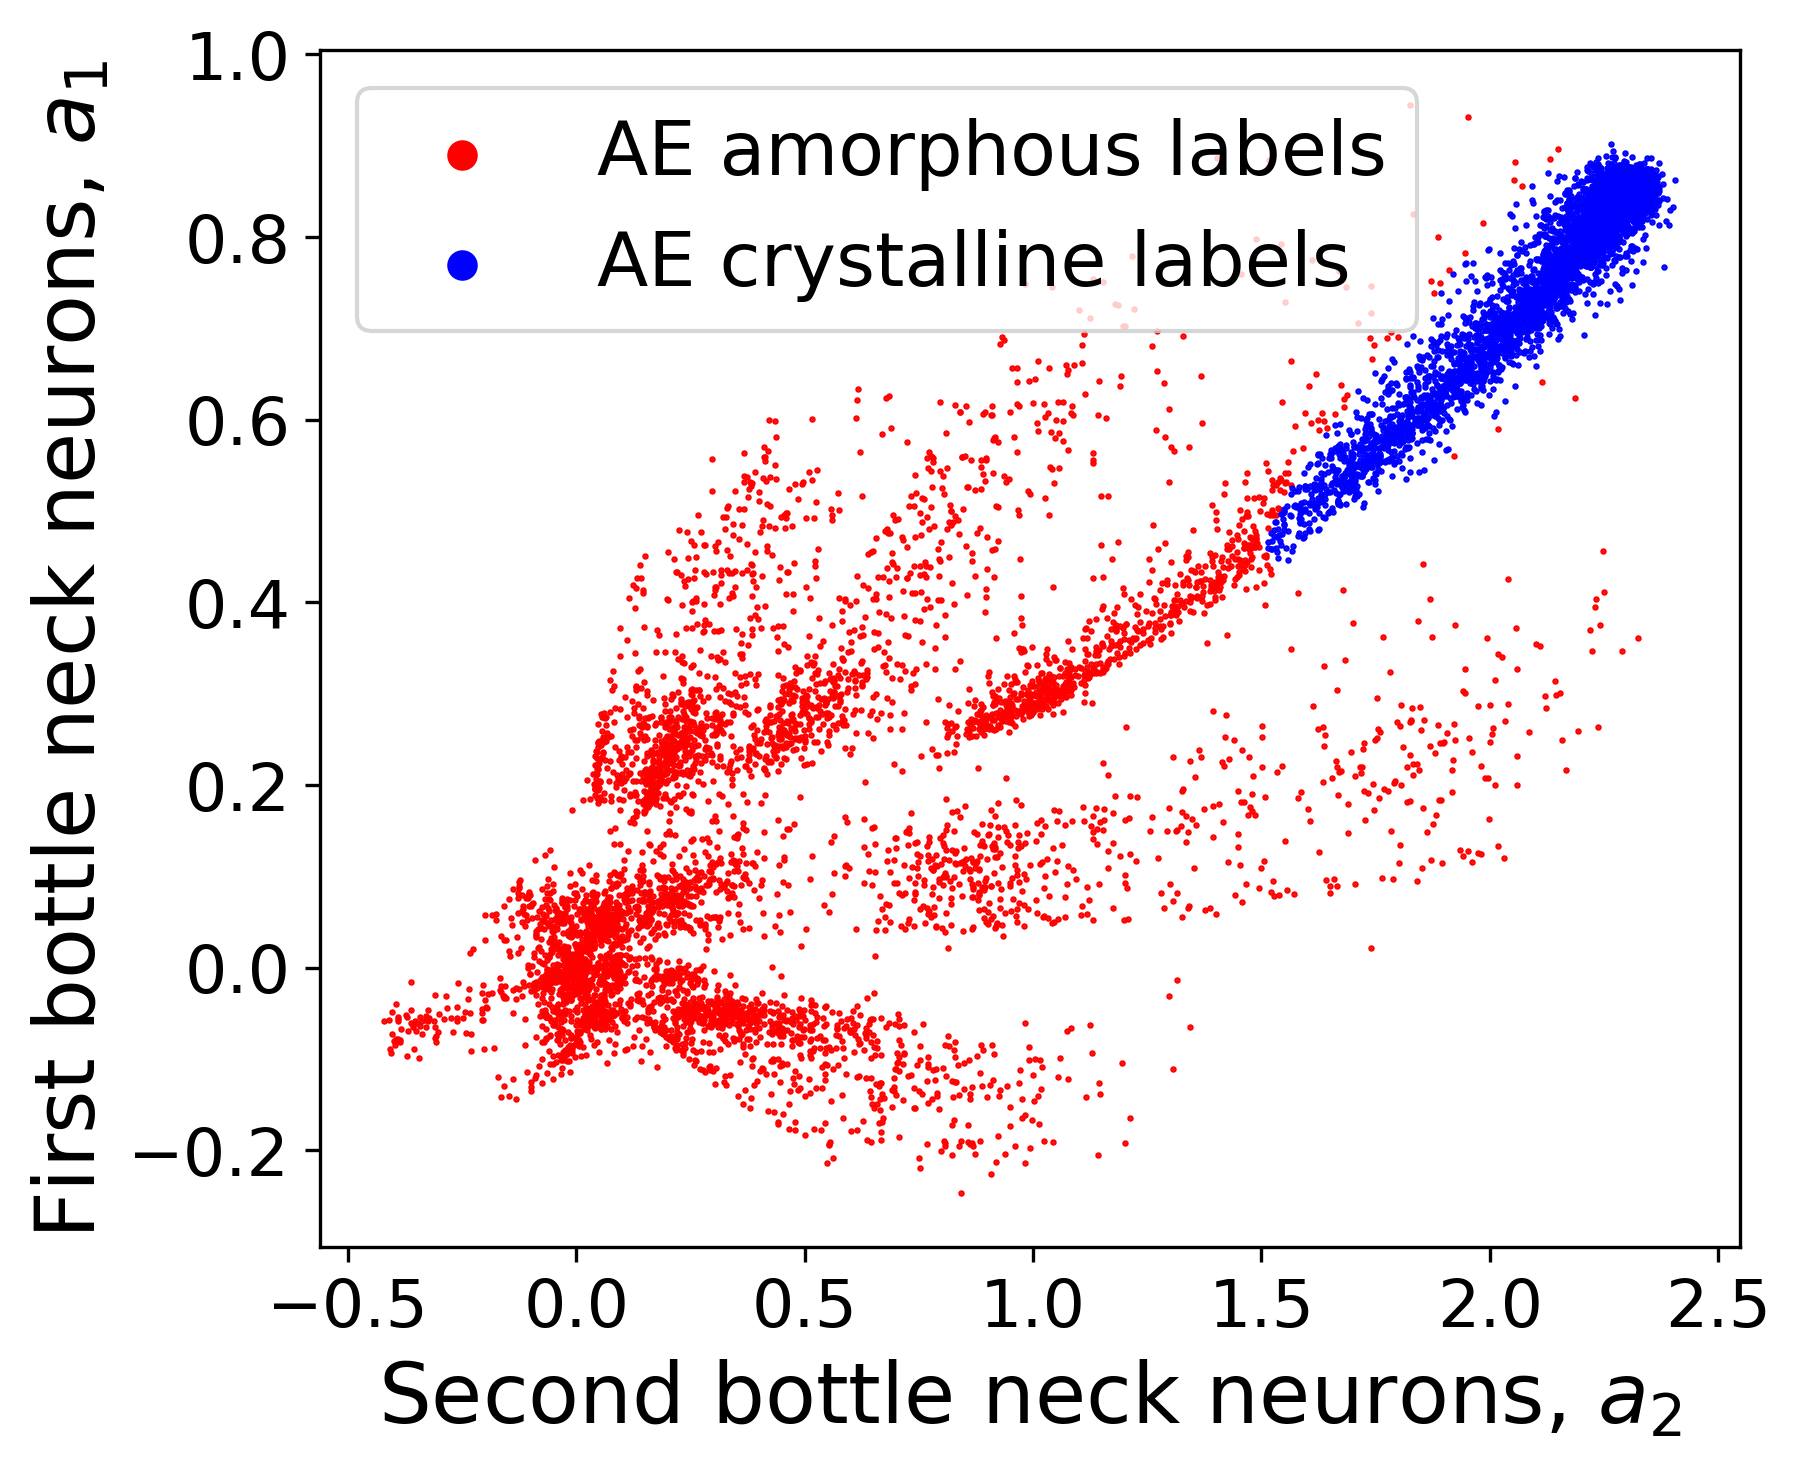

In [6]:
autoenc  = load_model("ae_slice.sav")
encoded  = autoenc.predict(ae_training_data)

gmm = mixture.GaussianMixture(n_components = 2, covariance_type = "full")
yhc = gmm.fit_predict(encoded)

fig = plt.figure()
p1 = encoded[yhc==0]
plt.scatter(p1[:,1], p1[:,0], c = 'red',  s = 0.3, label = 'AE amorphous labels')
p1 = encoded[yhc==1]
plt.scatter(p1[:,1], p1[:,0], c = 'blue', s = 0.3, label = 'AE crystalline labels')

plt.xlabel('Second bottle neck neurons, $a_2$', fontsize = 20)
plt.ylabel('First bottle neck neurons, $a_1$',  fontsize = 20)
lgnd     = plt.legend(fontsize=18)
for handle in lgnd.legendHandles:
    handle.set_sizes([40.0])
    
plt.tight_layout()
plt.show()


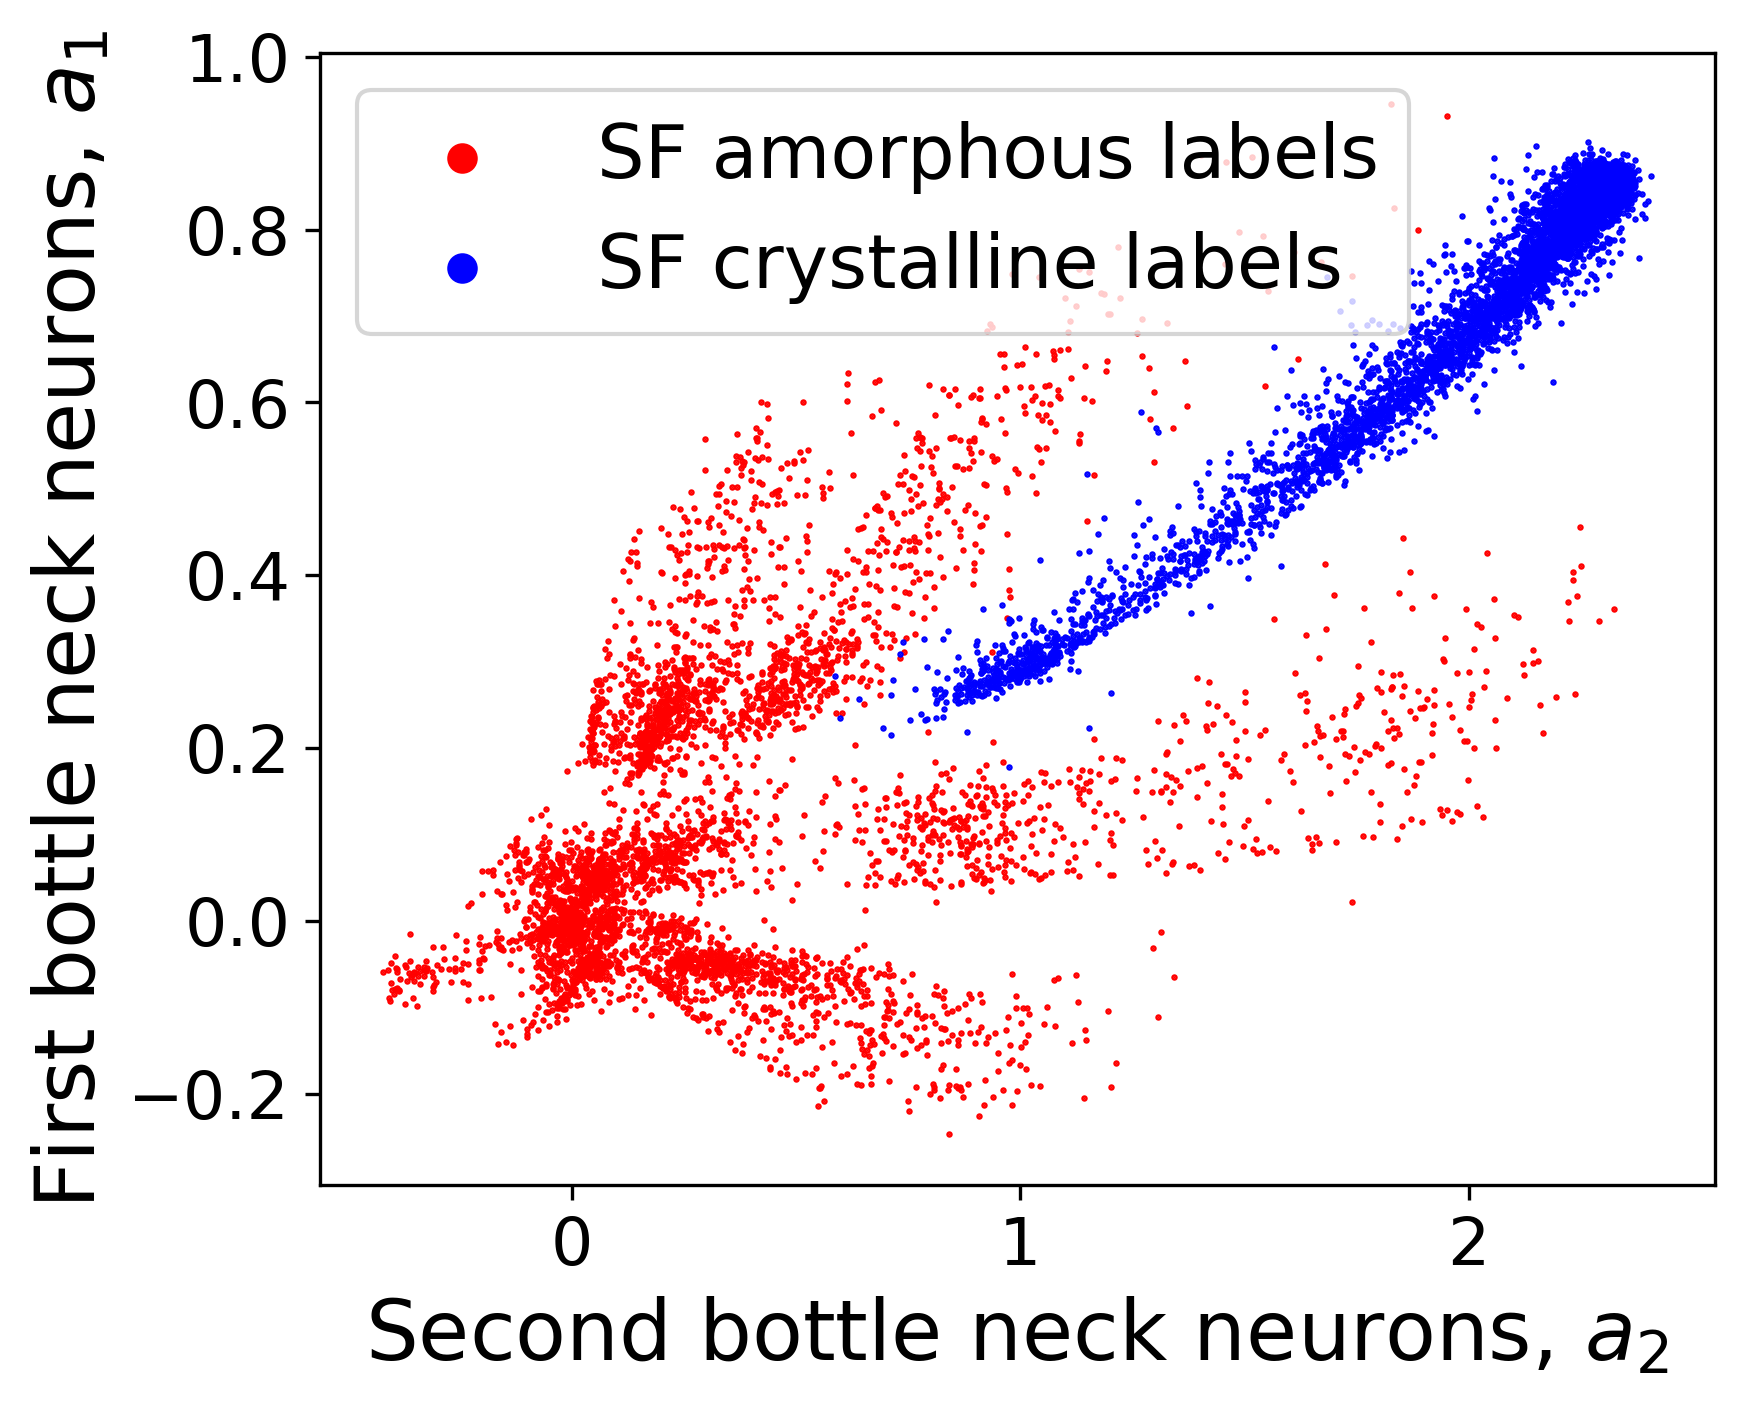

In [7]:
hc  = AgglomerativeClustering(n_clusters = 2, metric = 'euclidean', linkage = 'ward')
sf = hc.fit_predict(ae_training_data)

fig = plt.figure()
p1 = encoded[sf==0]
plt.scatter(p1[:,1], p1[:,0], c = 'red',  s = 0.3, label = 'SF amorphous labels')
p1 = encoded[sf==1]
plt.scatter(p1[:,1], p1[:,0], c = 'blue', s = 0.3, label = 'SF crystalline labels')

plt.xlabel('Second bottle neck neurons, $a_2$', fontsize = 20)
plt.ylabel('First bottle neck neurons, $a_1$',  fontsize = 20)
lgnd     = plt.legend(fontsize=18)
for handle in lgnd.legendHandles:
    handle.set_sizes([40.0])

In [9]:
yhcae = np.where(yhc==1)[0]
yhcff = np.where(sf ==1)[0]

sum(np.in1d(yhcae, yhcff))/len(yhcae)*100

100.0

## Predictions on the whole time series using the trained model

In [18]:
all_labels_ae  = []
all_encoded    = []
autoenc        = load_model('ae_slice.sav')

for i in np.arange(len(g)):
    
    training_data  = np.array(h5_file.get(h5_keys[i]))
    training_data  = np.delete(training_data, 10, axis = 1)
    encoded_output = autoenc.predict(training_data)
    all_encoded.append(encoded_output)
    
    label_ae   = gmm.predict(encoded_output)
    all_labels_ae.append(label_ae)
    print(i)
    
filename = 'AE_encoded.sav'
pickle.dump(all_encoded,     open(filename, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
filename = 'AE_labels.sav'
pickle.dump(all_labels_ae,   open(filename, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
